In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [3]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [4]:
test_matrix = np.load(f"mtx_segment_code_x_last_25_10_2nd.npy")

In [5]:
(test_matrix[:,0].astype(int)[500000:2000000] == se.index.values[500000:2000000]).all()

True

In [ ]:
# (np.sort(se.index.values) == se.index.values).all()

In [ ]:
# np.max(test_matrix[:,0])

In [ ]:
# sorted_matrix = test_matrix[se.index.values[:np.argmax(se.index.values>=3920086)],:]

In [ ]:
# sorted_matrix.shape

In [ ]:
# se = se.reset_index(drop=True)

# print("######################################")
# print("######################################")
# print("Is this right? Is this a massive hack?")
# print("######################################")
# print("######################################")

In [ ]:
# test_length = np.count_nonzero(se['test'])

# test_mask = se['test']

In [6]:
# 1st dimention is number of data points
# 2nd dimention is going back in time (in 10 min increments)
# 3rd dimention is prev-next segments

 

means = np.empty((500000, 25, 23)).astype(float)
counts = np.empty((500000, 25, 23)).astype(int)
index = np.empty((500000)).astype(int)

for idx, code in enumerate([
             'next_segment_code_11',
             'next_segment_code_10',
             'next_segment_code_9',
             'next_segment_code_8',
             'next_segment_code_7',
             'next_segment_code_6',
             'next_segment_code_5', 
             'next_segment_code_4', 
             'next_segment_code_3', 
             'next_segment_code_2', 
             'next_segment_code_1', 
             'segment_code',
             'prev_segment_code_1',
             'prev_segment_code_2',
             'prev_segment_code_3',
             'prev_segment_code_4',
             'prev_segment_code_5',
             'prev_segment_code_6',
             'prev_segment_code_7',
             'prev_segment_code_8',
             'prev_segment_code_9',
             'prev_segment_code_10',
             'prev_segment_code_11',
            ]):
    
    matrix = np.load(f"mtx_{code}_last_25_10.npy")
    
#     matrix = matrix[se.index.values[:np.argmax(se.index.values>=3920086)],:]
    
    means[:,:,idx] = matrix[:500000,1:26].astype(float)
    counts[:,:,idx] = matrix[:500000,26:].astype(int)
#     means[:,:,idx] = matrix[-500000:,1:26].astype(float)
#     counts[:,:,idx] = matrix[-500000:,26:].astype(int)
    if idx == 0:
        index = matrix[:500000,0].astype(int)
#         index = matrix[-500000:,0].astype(int)
        
  
    

In [ ]:
# se = se[:np.argmax(se.index.values>=3920086)]

In [7]:
(index == se.index[-500000:]).all()


False

In [8]:
def calc_offsets(means, counts, slices, axis, column_name, mask_threshold):
    
    mask = np.sum(counts[slices], axis=axis) > mask_threshold
    
    threshold_pass_fraction = np.count_nonzero(mask)/len(mask)
    
    if  threshold_pass_fraction < 0.25:
        raise ValueError('not enough data passing threshold')
    
    print(f"Approximately {threshold_pass_fraction*100:0.2f}% pass the threshold")
    
    data = means[slices][mask]
    
    weights = counts[slices][mask]
    
    masked_data = np.ma.masked_array(data, np.isnan(data))
    
    if column_name is not None:    
        se[column_name] = 0

        se.loc[mask, column_name] = np.ma.average(masked_data, axis=axis, weights=weights)
        
        return
    
    offsets = np.zeros(counts.shape[0])
    
    offsets[mask] = np.ma.average(masked_data, axis=axis, weights=weights)
    
    return offsets, threshold_pass_fraction, np.mean(np.sum(weights, axis=axis))

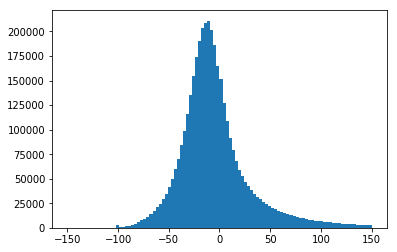

In [9]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));
# plt.hist(se['full_mean_minus_recent_15'], bins=100, range=(-150,150), alpha=0.5);

In [10]:
#Width of 2 and time of 100 with a threshold of 40

bus_counts = np.sum(counts[:,2:13,9:14], axis=(1,2))

dense_mask = (bus_counts>=40)

print(f"Fraction over 40: {(bus_counts>=40).sum()/bus_counts.shape[0]}")

Fraction over 40: 0.617424


Text(0.5, 1.0, 'Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments')

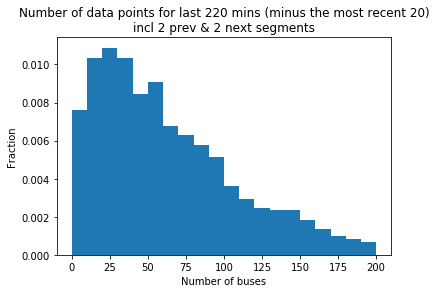

In [11]:
plt.hist(bus_counts, bins=20, range=(0,200), density=True);
plt.xlabel("Number of buses")
plt.ylabel("Fraction")
plt.title("Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments")

In [12]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [25]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [26]:
def calc_baseline_and_actual(number_of_rows=10000):
    
#     se_min = se[se['test']][:number_of_rows].copy()
    se_min = se[:number_of_rows].copy()
#     se_min = se[-number_of_rows:].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    se_min.reset_index(drop=True, inplace=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_15mins_mask = actual_array_cum < 15*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_15mins_mask] < actual_array_cum[first_15mins_mask] * 1.1) & \
                    (baseline_array_cum[first_15mins_mask] > actual_array_cum[first_15mins_mask] * 0.9))
    
    return baseline_array_cum, actual_array_cum, baseline_pass_count


In [27]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less


In [28]:
def calc_prediction_cum_journeys(column_name=None, offsets=None, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows = 10000):
    
#     se_min = se[se['test']][:number_of_rows].copy()
    se_min = se[:number_of_rows].copy()
#     se_min = se[-number_of_rows:].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets[:number_of_rows]/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min.reset_index(drop=True, inplace=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [29]:
def full_test(slices, threshold, baseline_array_cum, actual_array_cum, column_name=None, axis=(1,2), means=means, counts=counts, number_of_rows=10000):
    try:
        offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, slices, axis, column_name, threshold)
    except ValueError:
        print("Not enough values passed threshold")
        return [], 0, 0, 0, 0
    
    predict_array_cum, pass_count, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, number_of_rows=number_of_rows, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum)
    
    return predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights


..........................................................................................

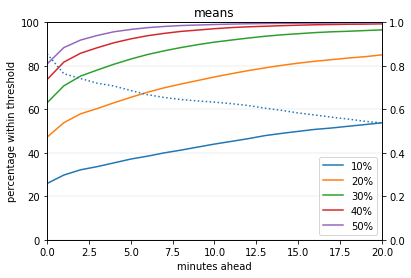

In [30]:
show_accuracy_minutes(baseline_array_cum, actual_array_cum, "means")

Approximately 30.04% pass the threshold


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


Approximately 0.34% improvment on baseline
Approximately 40.19% are in 10%
..........................................................................................

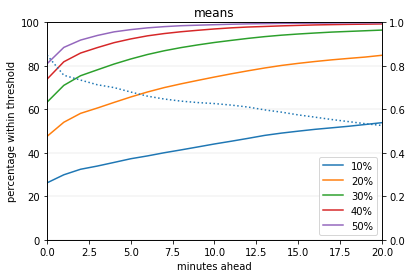

In [31]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, np.s_[:,2:11,10:13], (1,2), None, 40)

predict_array_dense2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_dense2_cum, actual_array_cum, "means")



Approximately 60.77% pass the threshold


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


Approximately 0.72% improvment on baseline
Approximately 40.34% are in 10%
..........................................................................................

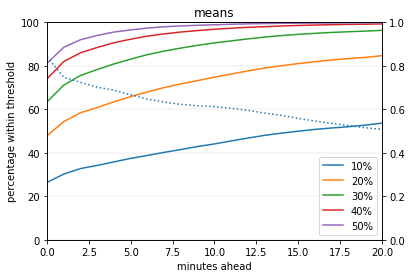

In [32]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, np.s_[:,2:13,9:14], (1,2), None, 40)

predict_array_dense_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_dense_cum, actual_array_cum, "means")


Approximately 91.86% pass the threshold


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


Approximately 0.93% improvment on baseline
Approximately 40.43% are in 10%
..........................................................................................

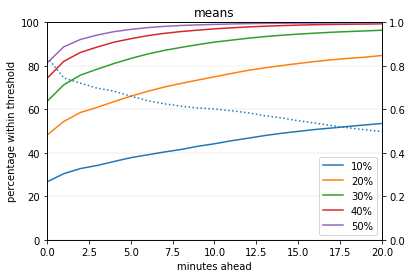

In [33]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, np.s_[:,2:23,1:22], (1,2), None, 60)

predict_array_sparse_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse_cum, actual_array_cum, "means")



Approximately 94.58% pass the threshold


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


Approximately 0.83% improvment on baseline
Approximately 40.39% are in 10%
..........................................................................................

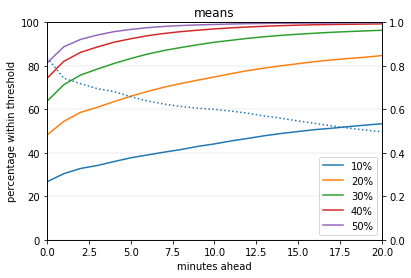

In [34]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, np.s_[:,2:23,1:22], (1,2), None, 40)

predict_array_sparse2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse2_cum, actual_array_cum, "means")


In [ ]:
# dense_mask = (bus_counts>40)

# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="mean sparse")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="predict sparse")
# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="mean dense")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="predict dense")


# # plt.plot(results_enh7[0,:], label="mean_enh7")
# # plt.plot(predict_array_cum[0,:], label="mean_enh_all")
# # plt.plot(with_15_90[0,:], label="with_15_90")
# # plt.plot(narrow_15_90[0,:], label="narrow_15_90")
# # plt.plot(narrow_15_90_t40[0,:], label="narrow_15_90_t40")
# # plt.plot(wide_15_45_t20[0,:], label="wide_15_45_t20")

# plt.legend()
# plt.xlim(0,20)
# plt.ylim(25,60)
# plt.title("Percentage of predictions within 10%")
# plt.xlabel("minutes ahead")
# plt.ylabel("percent within 10%")
# plt.show()

In [35]:
first_20mins_mask = actual_array_cum < 20*60

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [36]:
percentages_baseline = []
percentage_dense2_predict = []
percentage_dense_predict = []
percentage_sparse_predict = []
percentage_sparse2_predict = []
percentage_ave_predict = []

freqeuncy = []

x = np.array(range(27))*10

for i in x:

    full_mask = first_20mins_mask & (bus_counts>i)[:500000,None] & (bus_counts<i+10)[:500000,None]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    percentages_baseline.append(np.count_nonzero((baseline_array_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (baseline_array_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_dense2_predict.append(np.count_nonzero((predict_array_dense2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
        
    percentage_dense_predict.append(np.count_nonzero((predict_array_dense_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse_predict.append(np.count_nonzero((predict_array_sparse_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse2_predict.append(np.count_nonzero((predict_array_sparse2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    

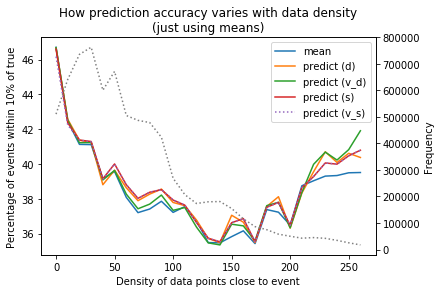

In [37]:
plt.plot(x, percentages_baseline, label="mean")
plt.plot(x, percentage_dense_predict, label="predict (d)")
plt.plot(x, percentage_dense2_predict, label="predict (v_d)")
plt.plot(x, percentage_sparse_predict, label="predict (s)")
plt.plot(x, percentage_sparse2_predict, label="predict (v_s)", ls=":")
plt.xlabel("Density of data points close to event")
plt.ylabel("Percentage of events within 10% of true")
plt.legend(loc=1)

ax = plt.gca()

ax2 = ax.twinx()

ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
plt.savefig("accuracy vs density.pdf")
plt.show()


In [ ]:
# baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

In [ ]:
# with open("post_noise_width_time_threshold_test3.csv", "w") as f: 
#     f.write("width,time,threshold,threshold_pass_fraction,mean_weights,pass_count,pass_fraction\n")
#     for width in range(0,12,2):
#         for time in range(2,24,3):
#             for threshold in [0,20,40,60,80,100,120,140,160,180,200,250,300]:
#                 print(f"w: {width}, t:20-{(time+3)*10}, t:{threshold}")
#     #             _, _, _, pass_count = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, number_of_rows=50000)
#                 predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,2:time+3,11-width:11+width+1], threshold, baseline_array_cum, actual_array_cum, number_of_rows=500000)
        
#                 f.write(f"{width},{(time+3)*10},{threshold},{threshold_pass_fraction},{mean_weights},{pass_count},{pass_fraction}\n")
#                 f.flush()
    
            
            